In [0]:
%matplotlib inline

In [2]:
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

     |████████████████████████████████| 634kB 8.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=d69f4be0422d02251c3d4aecc472ec3ac8be3e73f12b51d6717019f306c8412e
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Common/')

In [5]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip
from gradCAM import *
from lr_finder import *

  pip install torch-lr-finder -v --global-option="amp"


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 512
EPOCHS = 24
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)
train_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                              PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=0), 
                              RandomCrop(32, 32),
                              Cutout(num_holes=1, max_h_size=8, max_w_size=8),
                              HorizontalFlip()
                                ]
train_data_transfomrs = getAlbumTransformation(train_data_transforms_list)
trainloader = getTrainDataLoader("CIFAR", dataloader_args, train_data_transfomrs)
test_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
test_data_transfomrs = getAlbumTransformation(test_data_transforms_list)
testloader = getTestDataLoader("CIFAR", dataloader_args, test_data_transfomrs)
model = MyResNetS11().to(device)
summary(model, input_size=(3, 32, 32))



CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
    GhostBatchNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
    GhostBatchNorm-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
       BasicBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         294,912
        MaxPool2d-12            [-1, 256, 8, 8]               0
   GhostBatchN


Learning rate search finished. See the graph with {finder_name}.plot()


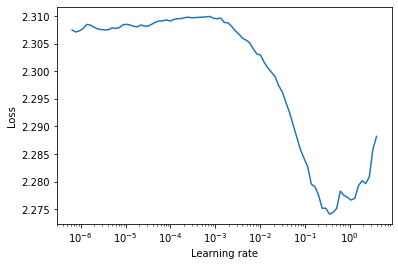

0.35111917342151344
Best Loss :  2.2741501078804585


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()
print(lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)])
print('Best Loss : ',lr_finder.best_loss)


Learning rate search finished. See the graph with {finder_name}.plot()


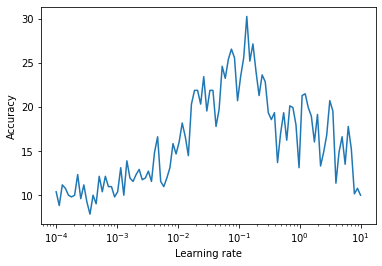

In [9]:
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp', accuracy=True)
lr_finder.plot_acc()
lr_finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.0005)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(trainloader), epochs=EPOCHS, pct_start=0.2, div_factor=5, final_div_factor=5)
all_train_acc = []

for epoch in range(EPOCHS):
  print('EPOCH : ', epoch)
  train(model, device, trainloader, optimizer, criterion)
  all_train_acc.append(train_acc[-1])
  test.__test(model, device, testloader, criterion)
  scheduler.step()
  

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH :  0


Loss=1.9641366004943848 Batch_id=97 Accuracy=34.52: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 4256/10000 (42.56%)

EPOCH :  1


Loss=1.966571569442749 Batch_id=97 Accuracy=47.06: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 4951/10000 (49.51%)

EPOCH :  2


Loss=1.8868070840835571 Batch_id=97 Accuracy=54.71: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 5397/10000 (53.97%)

EPOCH :  3


Loss=1.8505744934082031 Batch_id=97 Accuracy=60.76: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 5764/10000 (57.64%)

EPOCH :  4


Loss=1.816887617111206 Batch_id=97 Accuracy=64.64: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 5860/10000 (58.60%)

EPOCH :  5


Loss=1.7527188062667847 Batch_id=97 Accuracy=72.46: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 7218/10000 (72.18%)

EPOCH :  6


Loss=1.6550778150558472 Batch_id=97 Accuracy=76.90: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7760/10000 (77.60%)

EPOCH :  7


Loss=1.6980054378509521 Batch_id=97 Accuracy=78.45: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7727/10000 (77.27%)

EPOCH :  8


Loss=1.6567418575286865 Batch_id=97 Accuracy=80.26: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7719/10000 (77.19%)

EPOCH :  9


Loss=1.6219381093978882 Batch_id=97 Accuracy=81.46: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7736/10000 (77.36%)

EPOCH :  10


Loss=1.617537021636963 Batch_id=97 Accuracy=83.34: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8273/10000 (82.73%)

EPOCH :  11


Loss=1.6176234483718872 Batch_id=97 Accuracy=84.34: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8176/10000 (81.76%)

EPOCH :  12


Loss=1.631980299949646 Batch_id=97 Accuracy=85.22: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8352/10000 (83.52%)

EPOCH :  13


Loss=1.6379201412200928 Batch_id=97 Accuracy=85.82: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8183/10000 (81.83%)

EPOCH :  14


Loss=1.5967168807983398 Batch_id=97 Accuracy=86.54: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8373/10000 (83.73%)

EPOCH :  15


Loss=1.5919450521469116 Batch_id=97 Accuracy=87.07: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8368/10000 (83.68%)

EPOCH :  16


Loss=1.5675013065338135 Batch_id=97 Accuracy=87.57: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8332/10000 (83.32%)

EPOCH :  17


Loss=1.5880529880523682 Batch_id=97 Accuracy=88.24: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8505/10000 (85.05%)

EPOCH :  18


Loss=1.5784791707992554 Batch_id=97 Accuracy=88.48: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8383/10000 (83.83%)

EPOCH :  19


Loss=1.5723005533218384 Batch_id=97 Accuracy=89.20: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8578/10000 (85.78%)

EPOCH :  20


Loss=1.5989640951156616 Batch_id=97 Accuracy=89.68: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8434/10000 (84.34%)

EPOCH :  21


Loss=1.5521496534347534 Batch_id=97 Accuracy=89.91: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8308/10000 (83.08%)

EPOCH :  22


Loss=1.553710699081421 Batch_id=97 Accuracy=90.66: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8598/10000 (85.98%)

EPOCH :  23


Loss=1.5850296020507812 Batch_id=97 Accuracy=90.77: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.0032, Accuracy: 8540/10000 (85.40%)



In [0]:

!mkdir savedModels
import torch
modelName = 'cifar_myresnet18'
torch.save(model.state_dict(), "./savedModels/"+modelName+".pt")

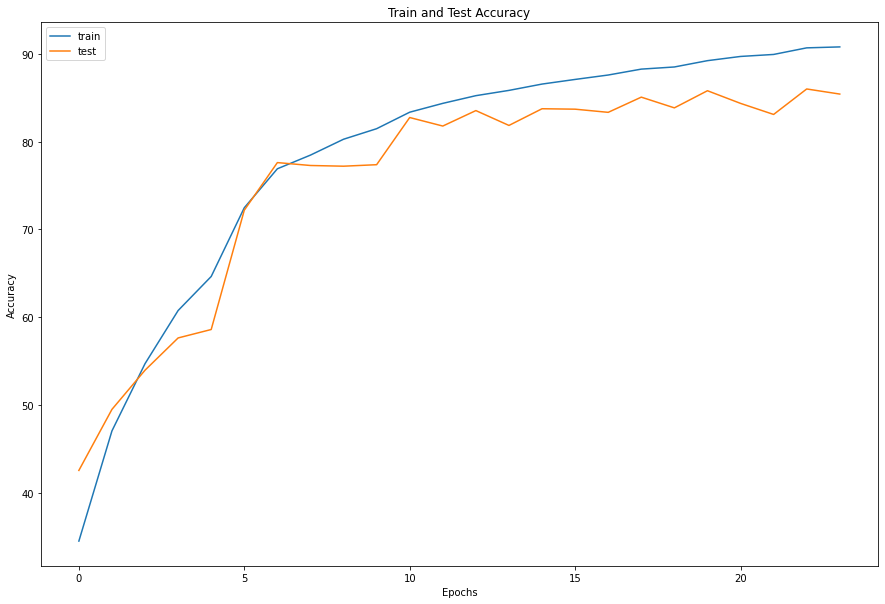

In [12]:
all_test_acc = {'train':all_train_acc,'test':test.test_acc}
plotGraph(all_test_acc, "Train and Test Accuracy","Epochs", "Accuracy")

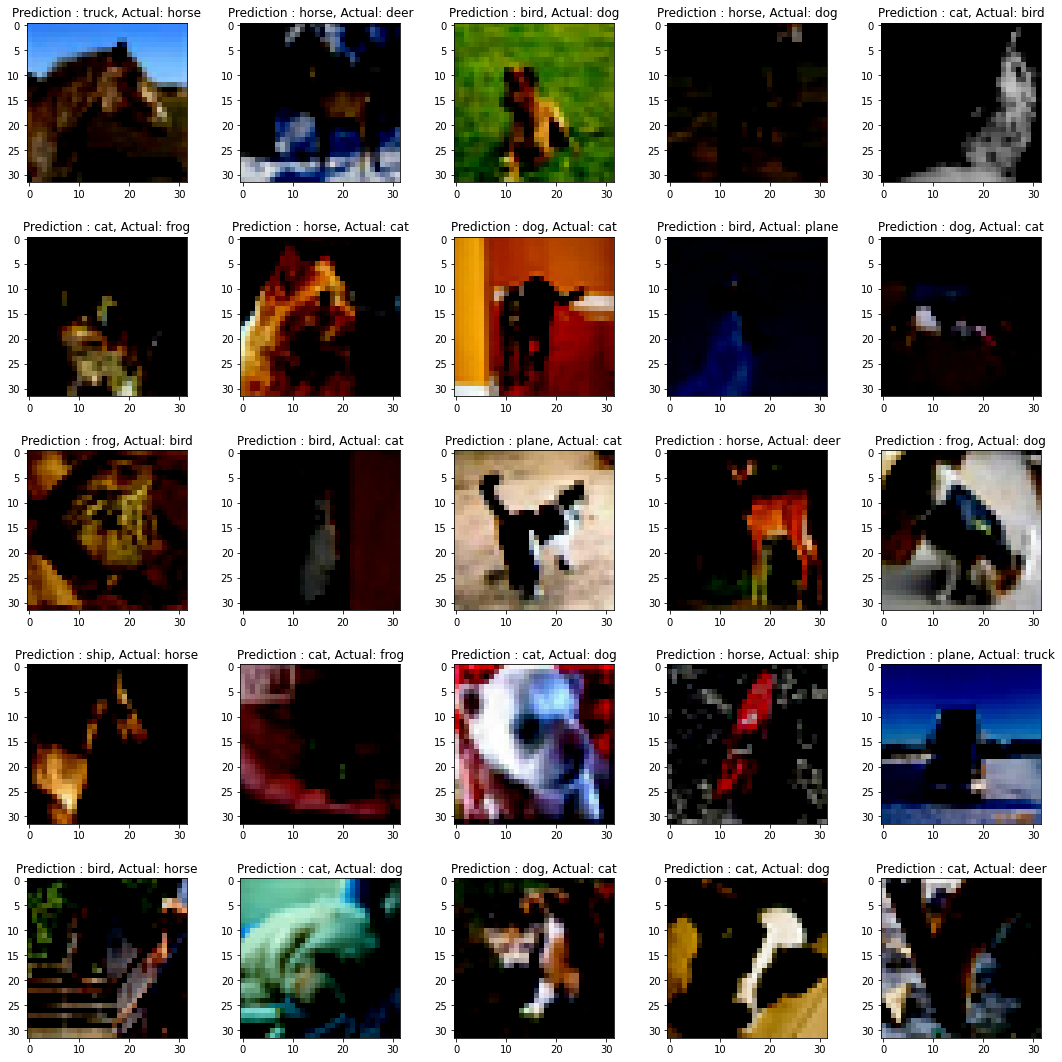

In [13]:
missClassImgs = getMisclassifiedImages(MyResNetS11(), testloader, device, 'savedModels/'+modelName+'.pt')
plotMisclassifiedImages(missClassImgs, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


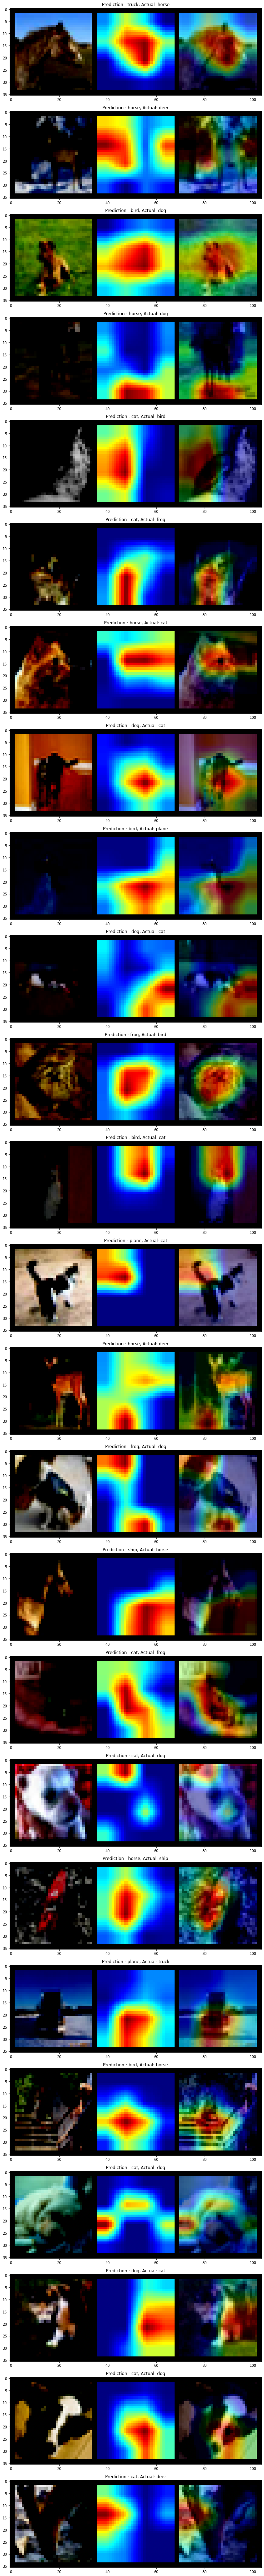

In [15]:
titles = getPredActualTitle(missClassImgs[:25], classes)
getGradCamOutput(MyResNetS11(), 'resnet', 'savedModels/'+modelName+'.pt', 'res2', missClassImgs[:25], titles)